<font color="FF3B3B"><h1 align="left">Sistema multimodal para la detección e identificación de especies de hongos mediante visión por computador y modelos de lenguaje</h1></font> 
<font color="#6E6E6E"><h2 align="left">Creación del data set final.</h2></font> 

#### David Alejandro Pedroza De Jesús

Inciamos las librerias necesarias para el proyecto.

In [1]:
import kagglehub
import tensorflow as tf
import numpy as np
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests
from bs4 import BeautifulSoup
import re

#   Descarga del dataset
Este código permite descargar el data set que será usado para el proyecto, su nombre es **Mushroom species recognition** por Leonardo Cofone, este contiene imagenes de 100 especies de hongos en varios estados de crecimiento y ambiente.No ejecutar en caso contrario debido a que el dataset usado tiene un peso de $11.3 \text{ GB}$

In [14]:
path = kagglehub.dataset_download("zlatan599/mushroom1",force_download = True)
print("Path to dataset files:", path)

100%|██████████| 11.3G/11.3G [06:13<00:00, 32.4MB/s]  


Extracting files...
Path to dataset files: C:\Users\David\.cache\kagglehub\datasets\zlatan599\mushroom1\versions\2


Ahora movemos el dataset al directorio de trabajo.

In [ ]:
origen = path
destino = os.getcwd() + "\\kaggle"
if not os.path.exists(destino):
    shutil.move(origen, destino)
    os.makedirs("..\\Datos")
    shutil.move(destino, "..\\Datos")
    print("Archivo movido")
else:
    print("El archivo ya existe en el destino.")
    

Archivo movido


#   Carga y revisión de los datos
Primero utilizamos pandas con la función `read_csv`, con esto podemomos obtener las rutas de nuestras imagenes y sus respectivas clases.

In [20]:
rutas_val = pd.read_csv(r"../Datos/kaggle/val.csv")
rutas_train = pd.read_csv(r"../Datos/kaggle/train.csv")
rutas_test = pd.read_csv(r"../Datos/kaggle/test.csv")

Ahora mostramos los subconjutos de datos para ver que todo esta correcto.

In [21]:
print(rutas_val.head())
print(f"Dimensiones del conjunto de validación: {rutas_val.shape}")

                                          image_path                    label
0  /kaggle/working/merged_dataset/Amanita muscari...         Amanita muscaria
1  /kaggle/working/merged_dataset/Fomes fomentari...        Fomes fomentarius
2  /kaggle/working/merged_dataset/Pseudevernia fu...  Pseudevernia furfuracea
3  /kaggle/working/merged_dataset/Graphis scripta...          Graphis scripta
4  /kaggle/working/merged_dataset/Omphalotus illu...      Omphalotus illudens
Dimensiones del conjunto de validación: (15616, 2)


In [22]:
rutas_train.head()
print(f"Dimensiones del conjunto de validación: {rutas_train.shape}")

Dimensiones del conjunto de validación: (689520, 2)


In [23]:
rutas_test.head()
print(f"Dimensiones del conjunto de validación: {rutas_test.shape}")

Dimensiones del conjunto de validación: (15614, 2)


In [24]:
print(f"Imagenes totales {rutas_val.shape[0] + rutas_train.shape[0] + rutas_test.shape[0]}")

Imagenes totales 720750


Ahora veremos cuantas especies hay en nuestro dataset

In [25]:
rutas_train.label.unique().shape

(169,)

Como vemos aquí, no hay ningun valor faltante.

In [26]:
data_sets = [rutas_train,rutas_val,rutas_test]
nombres = ["Entrenamiento", "Validación", "Test"]
for data_set,nombre in zip(data_sets, nombres):
    
    imagen_path_na = data_set.isna().sum()[0]
    label_na = data_set.isna().sum()[1]
    print(f"Conjunto de {nombre}")
    print(f"NAs en en las rutas de imagen {imagen_path_na}")
    print(f"NAs en en las etiquetas {label_na}")
    print("__________________________________________________")

Conjunto de Entrenamiento
NAs en en las rutas de imagen 0
NAs en en las etiquetas 0
__________________________________________________
Conjunto de Validación
NAs en en las rutas de imagen 0
NAs en en las etiquetas 0
__________________________________________________
Conjunto de Test
NAs en en las rutas de imagen 0
NAs en en las etiquetas 0
__________________________________________________


C:\Users\David\AppData\Local\Temp\ipykernel_8972\1456170254.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imagen_path_na = data_set.isna().sum()[0]
C:\Users\David\AppData\Local\Temp\ipykernel_8972\1456170254.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_na = data_set.isna().sum()[1]


Y las aquí mostramos las distribución de las especies por cada conjunto.Vemos que en el caso del entrenamiento tenemos la misma cantidad de imagenes para cada especie, mientras que eso no se repite en los demás datasets.

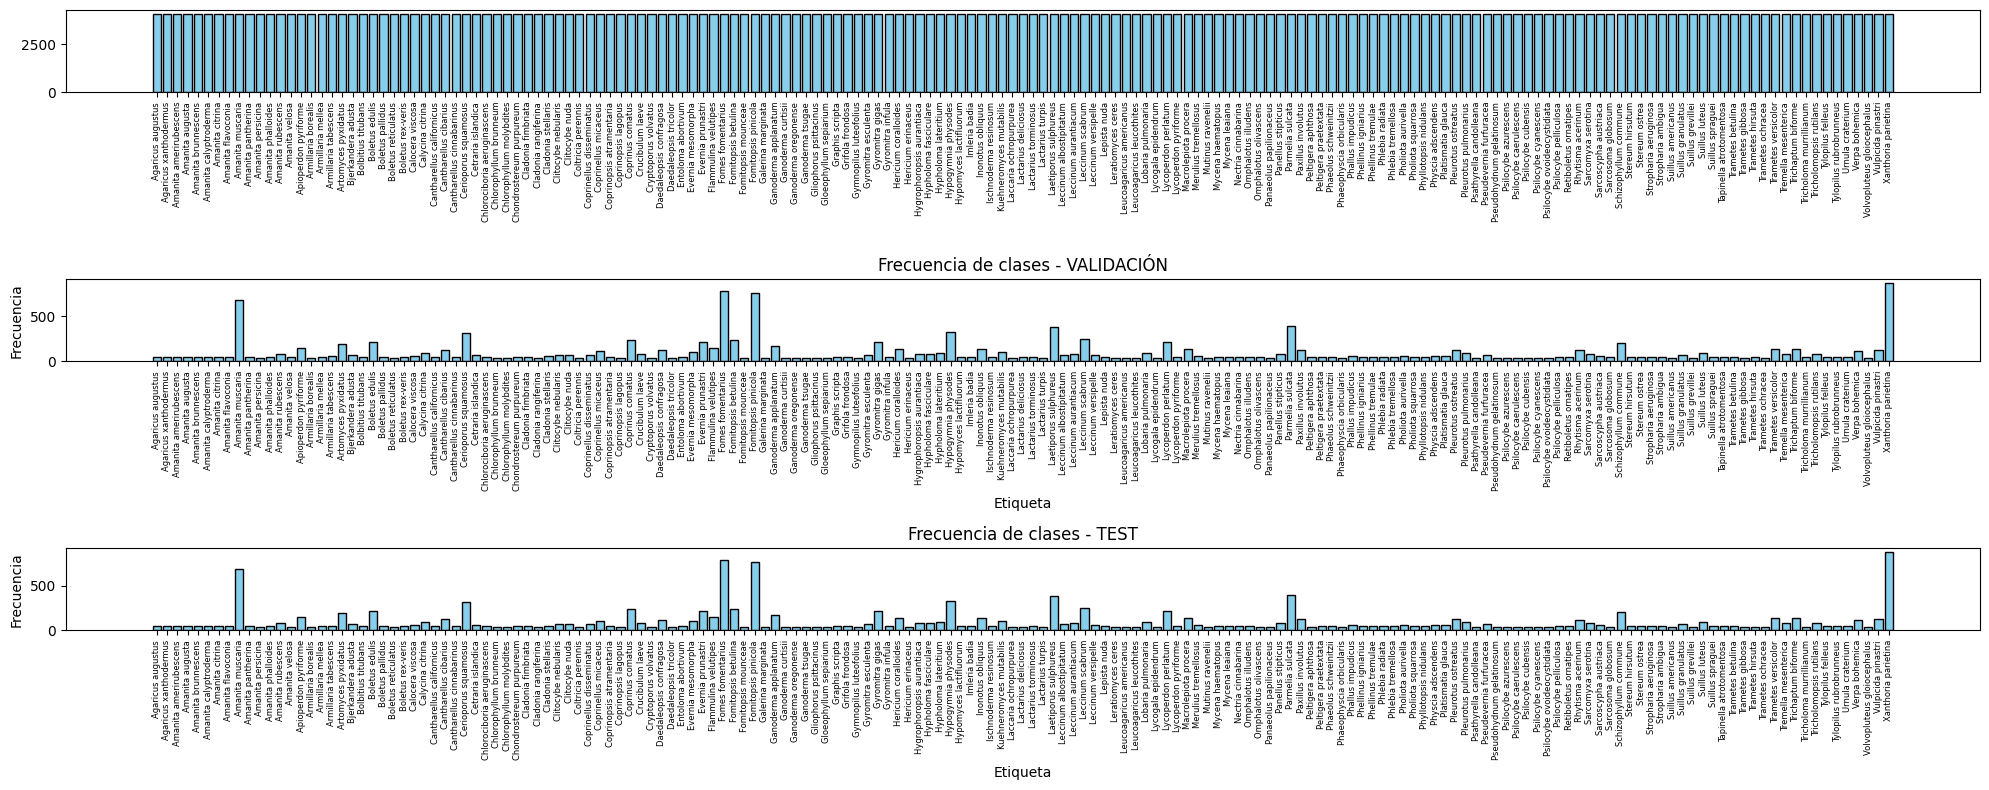

In [27]:
fig, axes = plt.subplots(3, figsize=(20, 8))

conteo_train = rutas_train["label"].value_counts().sort_index()
axes[0].bar(conteo_train.index, conteo_train, color='skyblue', edgecolor='black')
axes[0].tick_params(axis='x', rotation=90, labelsize=6)
axes[1].set_title("Frecuencia de clases - ENTRENAMINETO")
axes[1].set_xlabel("Etiqueta")
axes[1].set_ylabel("Frecuencia")


conteo_val = rutas_val["label"].value_counts().sort_index()
axes[1].bar(conteo_val.index, conteo_val, color='skyblue', edgecolor='black')
axes[1].tick_params(axis='x', rotation=90, labelsize=6)
axes[1].set_title("Frecuencia de clases - VALIDACIÓN")
axes[1].set_xlabel("Etiqueta")
axes[1].set_ylabel("Frecuencia")

conteo_test = rutas_test["label"].value_counts().sort_index()
axes[2].bar(conteo_test.index, conteo_test, color='skyblue', edgecolor='black')
axes[2].tick_params(axis='x', rotation=90, labelsize=6)
axes[2].set_title("Frecuencia de clases - TEST")
axes[2].set_xlabel("Etiqueta")
axes[2].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


##  Uso de sampling
El dataset es enorme por lo que no puedo cargarlo en mi ordenador y probablemente entrenar un modelo sería dificil.

In [28]:
def muestras_data_set(df,n, seed, use_seed):
    especies = pd.unique(df.label)
    df_final = pd.DataFrame(columns=df.columns)
    for especie in especies:
        df_fil = df[df.label == especie]
        if use_seed:
            df_fil = df_fil.sample(n=n, random_state=seed)
        else:
            df_fil = df_fil.sample(n=n)
        df_final = pd.concat([df_final, df_fil], ignore_index=True)
    return df_final

Aquí definimos las funciones para rescalar y cargar las imagenes.

In [42]:
def transform_images(x, size):
    x = tf.image.resize(x, (size, size))
    x = x / 255
    return x 

def dataset_generator(data, size = 255, n = 10, seed = 666, use_seed = False):
    data = muestras_data_set(data, n, seed, use_seed)
    paths = data.image_path
    labels = data.label
    images = []
    i = 0
    for path in paths:
        path = r"../Datos/" + path.lstrip("/").replace("/working", "")
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = transform_images(img, size)
        images.append(img.numpy())
    images = np.array(images)
    
    return images, labels

Por último cargaremos las imagenes usadon las rutas, esto nos permitirá tener un conjunto reducido de los datos originales.

-   Conjunto de entramiento reducido.

In [43]:
x_train, y_train = dataset_generator(rutas_train,seed = 666, use_seed = True)
print(f"Tamaño del conjunto de entrenamiento {x_train.shape}|{y_train.shape}")

Tamaño del conjunto de entrenamiento (1690, 255, 255, 3)|(1690,)


-   Conjunto de validación reducido.

In [44]:
x_val, y_val = dataset_generator(rutas_val,n = 5,seed = 666, use_seed = True)
print(f"Tamaño del conjunto de validación {x_val.shape}|{y_val.shape}")

Tamaño del conjunto de validación (845, 255, 255, 3)|(845,)


-   Conjunto de test reducido.

In [45]:
x_test, y_test = dataset_generator(rutas_test,n = 5,seed = 666, use_seed = True)
print(f"Tamaño del conjunto de validación {x_test.shape}|{y_test.shape}")

Tamaño del conjunto de validación (845, 255, 255, 3)|(845,)


## Filtrado de especies.

Otra cosa a considerar sería quedarnos solo con las especies de la comunidad valencian .Para ello usamos la web https://bdb.gva.es/, el cual es una base de datos pública con información sobre biodiveridad.

In [46]:
Especies_valencia = pd.read_excel(r"..\Datos_extra\Especies_hongosValencia.xlsx")
Especies_valencia = Especies_valencia.rename(columns={'Especie': 'label'})
Especies_valencia = Especies_valencia.label


Especies_valDF = pd.merge(Especies_valencia, rutas_train, on='label', how='inner')


print(f"Numero de especies del dataset presentes en Valencia {len(Especies_valDF.label.unique())}")
print(f"Numero de imagenes del conjunto de entramiento {Especies_valDF.shape}")
print(Especies_valDF.head())

Numero de especies del dataset presentes en Valencia 71
Numero de imagenes del conjunto de entramiento (289680, 2)
               label                                         image_path
0  Agaricus augustus  /kaggle/working/merged_dataset/Agaricus august...
1  Agaricus augustus  /kaggle/working/merged_dataset/Agaricus august...
2  Agaricus augustus  /kaggle/working/merged_dataset/Agaricus august...
3  Agaricus augustus  /kaggle/working/merged_dataset/Agaricus august...
4  Agaricus augustus  /kaggle/working/merged_dataset/Agaricus august...


##  Web scraping

Otra cosa que puede ser necesaria, sería saber apriori cuales especies son comestibles, debido a que a la hora de crea el modelo nos interesará ajustar el umbral para que clasifique bien las especies comestibles.El data set original no tiene esa información por lo que usaremos la wikipedia para esto.Para comprobar que tenemos toda la información allí usaremos el siguiente código.

In [47]:
def verificar(especie):
    url_base = "https://en.wikipedia.org/wiki/"
    dire = especie.replace(" ","_")
    url = url_base + dire
    url = url_base + dire
    headers = {
        "User-Agent": "MiTFG/1.0 (https://example.com; contacto@example.com)"
        }
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    content = soup.find_all("b")

    for i in content:
        texto = i.get_text(strip=True)
        rest = True
        if "Wikipedia does not have an article with this exact name" in texto:
            rest = False
            break
    return rest

In [48]:
Especies = Especies_valDF.label.unique()

Especies_encontradas = []
Especies_no_encontradas = []
for ruta in Especies:
    if verificar(ruta):
        Especies_encontradas.append(ruta)
    else:
        Especies_no_encontradas.append(ruta)

print(f"Especies con página de wikipedia {len(Especies_encontradas)}")
print(f"Especies sin página de wikipedia {len(Especies_no_encontradas)}")

Especies con página de wikipedia 69
Especies sin página de wikipedia 2


Vemos que todas las especies tienen su página en la wikipedia lo que hace más fácil todo, ahora procederemos a extraer la información de allí.Antes de trabajar con todas las páginas empezaremos solo con la primera.

In [49]:
url_base = "https://en.wikipedia.org/wiki/"
dire = Especies[Especies == "Boletus edulis"][0].replace(" ","_")
url = url_base + dire
headers = {
    "User-Agent": "MiTFG/1.0 (https://example.com; contacto@example.com)"
}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.text, 'html.parser')

In [50]:
content = soup.find_all('td', {"class": "infobox-data"})

for i in content:
    texto = i.get_text(strip=True)
    if "Edibility" in texto:
        print(texto.replace("Edibility is", "").strip())
        break


choice


Algunas de las paginas no tienen la tabla con la información si es venenosa o no, por lo que esos casos por el momento los dejaremos como **Na**.

In [51]:
def mushroms_info(especie):
    url_base = "https://en.wikipedia.org/wiki/"
    dire = especie.replace(" ","_")
    url = url_base + dire
    headers = {
        "User-Agent": "MiTFG/1.0 (https://example.com; contacto@example.com)"
    }
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    content = soup.find_all('td', {"class": "infobox-data"})

    clean_info = "Na"
    for i in content:
        texto = i.get_text(strip=True)
        if "Edibility" in texto:
            clean_info = texto.replace("Edibility is", "").strip()
            break

    return clean_info

In [52]:
info = []
for especie in Especies:
    info.append(mushroms_info(especie))
    
info = np.array(info)

Ahora ya tenemos la información para tener 3 clases:

-   `comestible` → todo lo que sea seguro o parcialmente comestible

-   `no comestible` → venenoso, mortal, o no recomendado

-   `na` → desconocido o no clasificado

In [53]:

comestibles = [
    'choice', 'choicebutnot recommended', 'edible', 'edible, butunpalatable',
    'ediblebutnot recommended', 'edibleor can causeallergic reactions',
    'edibleorpoisonous']

no_comestibles = [
    'deadly', 'poisonous', 'poisonousorpsychoactive', 
    'not recommended', 'not recommendedorpoisonous', 'inedible',
    'too hard to eat'
]

Desconocido = ['Na', 'unknown','edibleor inedible', 'choiceor inedible']


def map_edibility(x):
    if x in comestibles:
        return 'comestible'
    elif x in no_comestibles:
        return 'no comestible'
    else:
        return 'no se sabe'


edibility_simple = np.array([map_edibility(x) for x in info])

print(edibility_simple)


['comestible' 'no comestible' 'no comestible' 'no comestible'
 'no comestible' 'no comestible' 'comestible' 'comestible' 'no se sabe'
 'no comestible' 'comestible' 'comestible' 'no se sabe' 'comestible'
 'no se sabe' 'no se sabe' 'no comestible' 'no se sabe' 'no se sabe'
 'comestible' 'no se sabe' 'comestible' 'comestible' 'comestible'
 'comestible' 'no se sabe' 'comestible' 'no comestible' 'no comestible'
 'no comestible' 'no comestible' 'no comestible' 'no se sabe' 'comestible'
 'no comestible' 'comestible' 'no comestible' 'no se sabe' 'comestible'
 'comestible' 'no comestible' 'no se sabe' 'no se sabe' 'no se sabe'
 'comestible' 'no comestible' 'no comestible' 'no se sabe' 'no comestible'
 'no se sabe' 'no se sabe' 'comestible' 'no comestible' 'no comestible'
 'no se sabe' 'no se sabe' 'no se sabe' 'no se sabe' 'comestible'
 'comestible' 'comestible' 'no comestible' 'no comestible' 'no comestible'
 'no comestible' 'no comestible' 'comestible' 'comestible' 'comestible'
 'no se sabe' 

Por ultimo como solo hay dos especies que no tiene pagina de wikipedia lo añadiremos a mano, para ello se han usado estas páginas https://micoex.org/2016/09/17/coltricia-perennis/ y https://www.biodiversidadcanarias.es/biota/especie/C01169. Con esto creamos el df final modificando las dos entradas restantes.

In [54]:
df_info =pd.DataFrame({"label": Especies, "Info": edibility_simple})
print(f"Especies modificadas: {Especies_no_encontradas}")

df_info[df_info.label == "Coltricia perennis"].Info = "no comestible"

Especies modificadas: ['Coltricia perennis', 'Phaeophyscia orbicularis']


C:\Users\David\AppData\Local\Temp\ipykernel_8972\1077782271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info[df_info.label == "Coltricia perennis"].Info = "no comestible"


Por último filtraremos usando web scraping para quitar a los liquenes, debido a que son realciones simbioticas entre plantas y hongos por lo que no nos interesa para este proyecto.

In [55]:
def Limpieza(especie):
    url_base = "https://en.wikipedia.org/wiki/"
    dire = especie.replace(" ","_")
    url = url_base + dire
    headers = {
        "User-Agent": "MiTFG/1.0 (https://example.com; contacto@example.com)"
    }
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    content = soup.find_all('p')

    clean_info = True
    for i in content:
        texto = i.get_text(strip=True)
        if "lichen" in texto:
        #if "lichen" in texto or "pathogen" in texto:
            clean_info = False
            break

    return clean_info

Con la función anterior marcamos como falso los valores que son liquenes y filtramos el data set para el final.

In [ ]:
Incluir = []
for i in df_info["label"]:
    Incluir.append(Limpieza(i))
Incluir = np.array(Incluir)

In [ ]:
df_info_final = df_info[Incluir]
df_info_final.shape

(57, 2)

# Casos de no se sabe

En este punto investigaremos por separado los casos en los que no sabemos si son comestibles o no debido a que puede que su pagina de la wikipedia, por lo que requieren más trabajo.

In [ ]:
num_casos_des = df_info_final[df_info_final.Info == "no se sabe"].shape[0]
print(f"Numero de casos: {num_casos_des}")

Numero de casos: 9


In [ ]:
df_info_final[df_info_final.Info == "no se sabe"].label

8            Armillaria tabescens
12               Calocera viscosa
15    Chlorociboria aeruginascens
17       Chondrostereum purpureum
20             Coltricia perennis
42            Lycoperdon perlatum
43           Lycoperdon pyriforme
50       Phaeophyscia orbicularis
57              Rhytisma acerinum
Name: label, dtype: object

## Armillaria tabescens

Según la siguiente pagina https://en.wikipedia.org/wiki/Desarmillaria_tabescens dice que esta especie puede en teoria ser cocinada y comida pero se han reportado que puede causar enfermedades del estomago, además de contener toxinas que pueden ser malas para la salud, por lo que se optará por dejarlo en no comestible

In [ ]:
df_info_final.loc[df_info_final.label == "Armillaria tabescens", "Info"] = "comestible"

C:\Users\David\AppData\Local\Temp\ipykernel_12600\4257443092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info_final.loc[df_info_final.label == "Armillaria tabescens", "Info"] = "comestible"


##  Calocera viscosa

según la siguiente página https://ca.wikipedia.org/wiki/Banya_viscosa, dice claramente que no es comestible, por lo que lo cambiamos como corresponde.

In [ ]:
df_info_final.loc[df_info_final.label == "Calocera viscosa", "Info"] = "no comestible"

C:\Users\David\AppData\Local\Temp\ipykernel_12600\3266007849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info_final.loc[df_info_final.label == "Calocera viscosa", "Info"] = "no comestible"


## Chlorociboria aeruginascens

Según esta página https://www.fungipedia.org/hongos/chlorociboria-aeruginascens.html indica claramente no comestible.

In [ ]:
df_info_final.loc[df_info_final.label == "Chlorociboria aeruginascens", "Info"] = "no comestible"

C:\Users\David\AppData\Local\Temp\ipykernel_12600\1549141632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info_final.loc[df_info_final.label == "Chlorociboria aeruginascens", "Info"] = "no comestible"


## Chondrostereum purpureum

En este caso muchas páginas indican que no hay ni interes culinario o siguiera información sombre si es venenoso o no, por lo que para simplificar el problema y como es claramente es algo que no es una seta en si lo mejor sería quitarlo.https://www.fichasmicologicas.com/?micos=1&alf=c&s=mycena%20pura&art=1080

In [ ]:
df_info_final = df_info_final[df_info_final.label != "Chondrostereum purpureum"]

## Coltricia perennis

En esta página https://www.amanitacesarea.com/coltricia-perennis.html#:~:text=%2D%20Carne:%20Delgada%2C%20el%C3%A1stica%20y,hace%20referencia%20a%20silla%2C%20asiento. podemos ver claramente que la seta en custión no es comestible, pero no debido a que sea venenosa si no que es dura y no tiene valor culinario en sí.

In [ ]:
df_info_final.loc[df_info_final.label == "Coltricia perennis", "Info"] = "no comestible"

##  Lycoperdon perlatum

Según la wikipedia esta especie es comestible, pero solo cuando la carne es blanda, este además remarca que el valor gastronomico es mediocre, por lo que sería lo mejor dejarla como no comestible.https://es.wikipedia.org/wiki/Lycoperdon_perlatum

In [ ]:
df_info_final.loc[df_info_final.label == "Lycoperdon perlatum", "Info"] = "no comestible"

## Lycoperdon pyriforme

Este caso es más complicado, ya que puede consumirse si es joven algunas fuentes dicen que tiene un valor culinario moderado aunque otras dicen que no lo tiene, de la misma manera en en el caso anterior lo dejaremos en no comestible.https://www.aranzadi.eus/index.php/buscador-micologico/ficha/1-4-014.09.18.00.05.00 https://es.wikipedia.org/wiki/Lycoperdon_pyriforme

In [ ]:
df_info_final.loc[df_info_final.label == "Lycoperdon pyriforme", "Info"] = "no comestible"

## Phaeophyscia orbicularis

Este según esta página https://www.biodiversidadcanarias.es/biota/especie/C01169 es un liquen, por lo que siguiendo criterios anteriores lo quitaremos.

In [ ]:
df_info_final = df_info_final[df_info_final.label != "Phaeophyscia orbicularis"]

## Rhytisma acerinum

Este no es una seta sino que es un hongo patogeno que afecta solo a las plantas, esto no es lo que buscamos en el proyecto ya que nadie recogerá esto cuando va a buscar setas en la montaña. https://es.wikipedia.org/wiki/Rhytisma_acerinum

In [ ]:
df_info_final = df_info_final[df_info_final.label != "Rhytisma acerinum"]

#   Conclusión

Por último guardamos la información obtenida en un csv por si wikipedia decide cambiar la estructura de las páginas.

In [ ]:
df_info_final.to_csv(r'TFG\Datos_extra\InfoEspecies.csv')
df_info_final.head()

,label,Info
0,Agaricus augustus,comestible
1,Agaricus xanthodermus,no comestible
2,Amanita citrina,no comestible
3,Amanita muscaria,no comestible
4,Amanita pantherina,no comestible


También guardaremos los labels en formato txt para el modelo que usaremos en la TPU.

In [ ]:
np.array(df_info_final.label).tofile(r'TFG\Datos_extra\labels.txt', sep = ',\n')